## Figure 3

In [1]:
import mne
import numpy as np
import csv
from glob import glob
from tqdm.notebook import tqdm
import h5py
import seaborn
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
from matplotlib.gridspec import GridSpec
from matplotlib import cm
rc['pdf.fonttype'] = 42
plt.style.use('seaborn')
import sys
sys.path.append('../preprocessing/utils/')
import strf

In [2]:
# Change these path for running the notebook locally
eeg_data_path = '/path/to/dataset/' # downloadable from OSF: https://doi.org/10.17605/OSF.IO/FNRD9
git_path  = '/path/to/git/speaker_induced_suppression_EEG/'
# Where the output of train_linear_model.ipynb is saved. Run that first if you haven't already.
# Alternatively, model h5 are available in the OSF repository, in folder `linear_encoding_model_results`.
h5_path = '/path/to/h5/'

In [3]:
perception_color = '#117733'
production_color = '#332288'
predictable_color = '#ddcc77'
unpredictable_color = '#aa4499'
picks = ['F1','Fz','F2','FC1','FCz','FC2','C1','Cz','C2']
tmin,tmax = -.3, .5
delays = np.arange(np.floor(tmin*128),np.ceil(tmax*128),dtype=int)
exclude = ['OP0001','OP0002','OP0020']
subjs = np.sort([s[-6:] for s in glob(f'{git_path}eventfiles/*') if 'OP0' in s and s[-6:] not in exclude])
models = ['model1','model1e','model2','model2e','model3','model3e','model4','model4e']
features = {model_number:strf.get_feats(model_number=model_number,extend_labels=True) for model_number in models}
n_feats = {model_number:len(features[model_number]) for model_number in models}

### Load data

In [4]:
# Load STRF data from hdf5
wts, corrs, pvals, sig_wts, sig_corrs, alphas = dict(), dict(), dict(), dict(), dict(), dict()
for m in tqdm(models):
    wts[m], corrs[m], pvals[m], sig_wts[m], sig_corrs[m], alphas[m] = dict(), dict(), dict(), dict(), dict(), dict()
    for s in subjs:
        f = h5py.File(f'{h5_path}{m}/{s}_strf.hdf5', 'r')
        wts[m][s] = np.array(f.get("wts"))
        corrs[m][s] = np.array(f.get("corrs"))
        pvals[m][s] = np.array(f.get("pvals"))
        alphas[m][s] = np.array(f.get("alphas"))
        f.close()
    # Extract significant weights, corrs
    for s in subjs:
        nchans = wts[m][s].shape[2]
        sig_wts[m][s] = np.zeros((len(delays),n_feats[m],nchans))
        sig_corrs[m][s] = np.zeros((nchans))
        for i in np.arange(nchans):
            if pvals[m][s][i] < 0.01:
                sig_wts[m][s][i] = wts[m][s][i]
                sig_corrs[m][s][i] = corrs[m][s][i]

  0%|          | 0/8 [00:00<?, ?it/s]

### Plotting

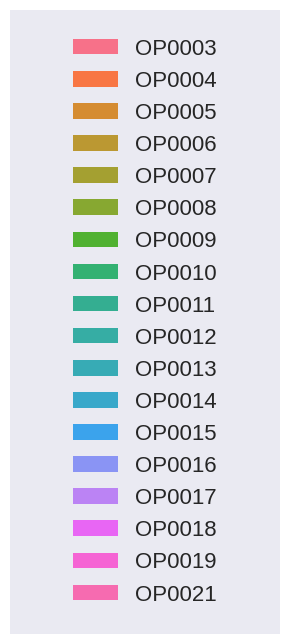

In [5]:
# legend
fontsize=16
subj_colors = seaborn.color_palette("husl",n_colors=len(subjs))
plt.figure(figsize=(3,7))
for i,s in enumerate(subjs):
    plt.bar(0,0,color=subj_colors[i],label=s)
plt.legend(loc='center',fontsize=fontsize)
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()

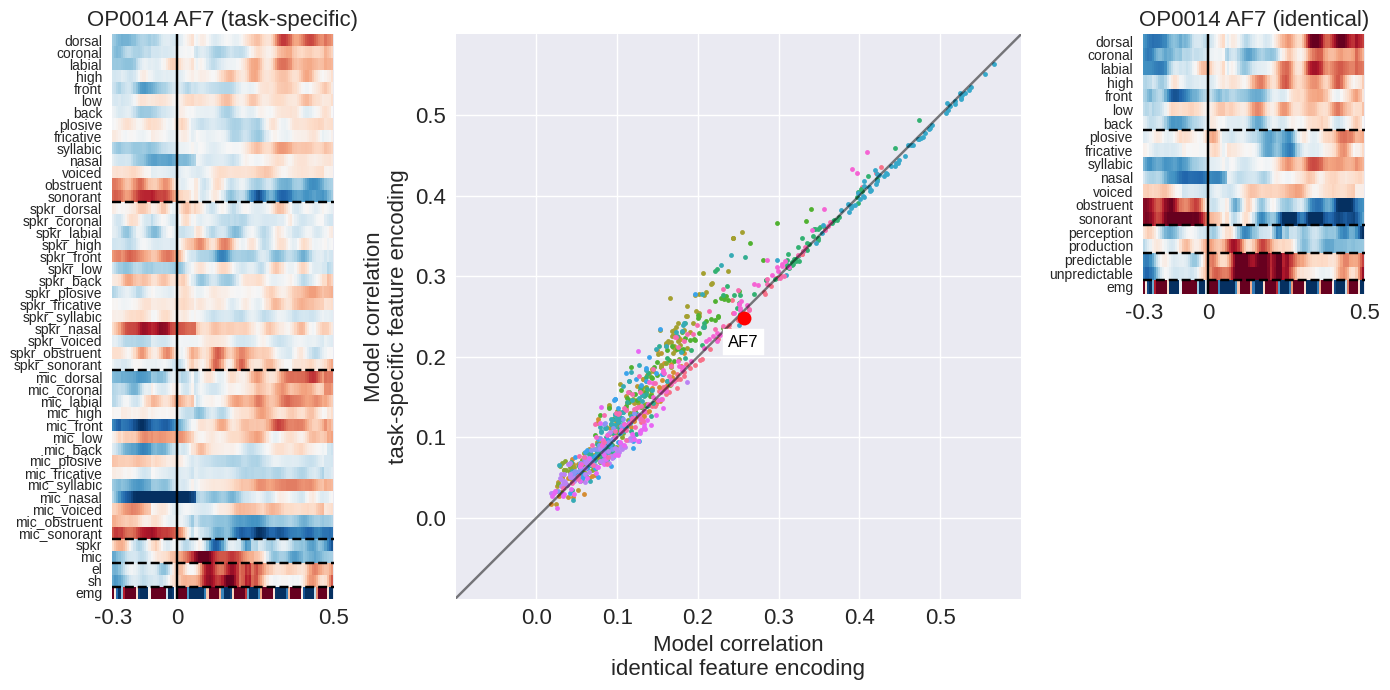

In [6]:
# Panels A, B, C
no_scatter = ['OP0004','OP0012']
top_elecs,ch_names = dict(),dict()
xm, xl = 'model1', 'Model correlation\nidentical feature encoding'
ym, yl = 'model2', 'Model correlation\ntask-specific feature encoding'
fig = plt.figure(figsize=(14,7))
gs = GridSpec(8, 8, figure=fig)
axes = []
# Panel B
axes.append(fig.add_subplot(gs[:,2:6]))
for cid,s in enumerate(subjs):
    if s not in no_scatter:
        top_elecs[s] = dict()
        ch_names[s] = mne.io.read_raw_brainvision(
            f'{eeg_data_path}{s}/{s}_B1/{s}_B1_cca.vhdr',verbose=False,preload=False).info['ch_names']
        for i, p in enumerate(corrs[xm][s]):
            if sig_corrs[xm][s][i] != 0 and sig_corrs[ym][s][i] != 0:
                plt.plot(sig_corrs[xm][s][i],sig_corrs[ym][s][i],'.',color=subj_colors[cid])
                if corrs[xm][s].mean(0) >= .2 or corrs[ym][s].mean(0) >= .2:
                    top_elecs[s][ch_names[s][i]] = sig_corrs[xm][s][i]-sig_corrs[ym][s][i]
min_corr, max_corr = -0.1, 0.6
plt.plot([min_corr,max_corr],[min_corr,max_corr],color='k',label='unity',alpha=0.5);
plt.gca().set_ylim([min_corr,max_corr]);
plt.gca().set_xlim([min_corr,max_corr]);
ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.gca().set_xticks(ticks)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(ticks,fontsize=fontsize)
plt.gca().set_xticklabels(ticks,fontsize=fontsize)
plt.xlabel(xl,fontsize=fontsize);
plt.ylabel(yl,fontsize=fontsize);
vmin, vmax = -0.2,0.2
max_idxs = np.argpartition(np.vstack(
    [top_elecs[s][e] for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys()])[:,0],-4)[-4:]
min_idxs = np.argpartition(np.vstack(
    [top_elecs[s][e] for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys()])[:,0],4)[:4]
max_corrs = np.vstack([top_elecs[s][e] for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys()])[max_idxs,0]
min_corrs = np.vstack([top_elecs[s][e] for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys()])[min_idxs,0]
top_subj = [s for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys() if top_elecs[s][e] in max_corrs]
top_ch_names = [e for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys() if top_elecs[s][e] in max_corrs]
min_subj = [s for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys() if top_elecs[s][e] in min_corrs]
min_ch_names = [e for s in [s for s in subjs if s not in no_scatter] for e in top_elecs[s].keys() if top_elecs[s][e] in min_corrs]
top_elec_colors = seaborn.color_palette("Set2",n_colors=4)
plt.text(sig_corrs[xm][top_subj[-1]][ch_names[top_subj[-1]].index(top_ch_names[-1])],
         sig_corrs[ym][top_subj[-1]][ch_names[top_subj[-1]].index(top_ch_names[-1])]-0.03,
         top_ch_names[-1],color='k',fontsize=12,ha='center',va='center',backgroundcolor='w')
plt.plot(sig_corrs[xm][top_subj[-1]][ch_names[top_subj[-1]].index(top_ch_names[-1])],
         sig_corrs[ym][top_subj[-1]][ch_names[top_subj[-1]].index(top_ch_names[-1])],'.',ms=20,color='r')
# Panel C
axes.append(fig.add_subplot(gs[:4,6:]))
i = -1
s = top_subj[i]
plt.imshow(
    wts[xm][s][:,:,ch_names[s].index(top_ch_names[i])].T,cmap=cm.RdBu_r,
    vmin=vmin,vmax=vmax,aspect='auto',interpolation='nearest')
plt.gca().set_xticks([0, 100*-tmin, len(delays)])
plt.gca().set_xticklabels([tmin, 0, tmax],fontsize=fontsize)
plt.gca().set_yticks(np.arange(len(features[xm])))
plt.gca().set_yticklabels(features[xm])
plt.axvline(100*-tmin,color='k')
plt.axhline(6.5,linestyle='--',color='black')
plt.axhline(13.5,linestyle='--',color='black')
plt.axhline(15.5,linestyle='--',color='black')
plt.axhline(17.5,linestyle='--',color='black')
plt.title(f'{top_subj[i]} {top_ch_names[i]} (identical)',fontsize = fontsize)
plt.grid(False)
# Panel A
axes.append(fig.add_subplot(gs[:,:2]))
i = -1
s = top_subj[i]
plt.imshow(
    wts[ym][s][:,:,ch_names[s].index(top_ch_names[i])].T,cmap=cm.RdBu_r,
    vmin=vmin, vmax=vmax, aspect='auto',interpolation='nearest')
plt.gca().set_xticks([0, 100*-tmin, len(delays)])
plt.gca().set_xticklabels([tmin, 0, tmax],fontsize=fontsize)
plt.gca().set_yticks(np.arange(len(features[ym])))
plt.gca().set_yticklabels(features[ym])
plt.axvline(100*-tmin,color='k')
plt.axhline(13.5,linestyle='--',color='black')
plt.axhline(27.5,linestyle='--',color='black')
plt.axhline(41.5,linestyle='--',color='black')
plt.axhline(43.5,linestyle='--',color='black')
plt.axhline(45.5,linestyle='--',color='black')
plt.title(f'{top_subj[i]} {top_ch_names[i]} (task-specific)', fontsize = fontsize)
plt.grid(False)
plt.tight_layout()